In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import re
import optuna
from optuna.samplers import RandomSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer #модель для автозаполнения пустых ячеек

# from ydata_profiling import ProfileReport # подробный разбор признаков
data_patch = '.\\'

In [2]:
# Miss - обращение к незамужней девушке в англоязычных государствах и странах
# Mrs [ˈmɪsɪz] — миссис - Это обращение к замужней женщине на английском языке
# Master - для юношей
# Dr - доктор
# Rev - Reverend - преподобный
# Mlle - для обращения к незамужним женщинам
# Major - военный
# Capt - военный
# Jonkheer - молодой лорд
# Mme - мадам
# Col - полковник
# the Countess - графиня
# Ms - женщина
# Don - профессор

def preprocessing_data(filename, dummies=False, polynomial=False, test=False):
    
    dataframe = pd.read_csv(filename).copy()
    if test:
        dataframe['PassengerId'].to_csv('gender_submission.csv', sep=',', index=False)
    else:
        survived = dataframe['Survived']
        
    dataframe = dataframe.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
    #mask = dataframe['Age'].isna()
    #dataframe.loc[mask, 'Age'] = np.random.randint(10, 50, mask.sum())
    dataframe['Embarked'] = dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0])
    dataframe['Sex'] = dataframe['Sex'].map({'male':1,'female':0})
    dataframe['Embarked'] = dataframe['Embarked'].map({'S':0,'C':1, 'Q':2})
    dataframe['Name'] = dataframe['Name'].apply(lambda x: re.search(r', \w*', x)[0][2:])
    replacements = {
        'Master': 1,
        'Mrs': 2,
        'Mr': 4,
        'Miss': 3,
        'Dr': 4,
        'Rev': 4,
        'Major': 4,
        'Col': 4,
        'Capt': 4,
        'Sir': 4,
        'Don': 4,
        'Jonkheer': 4,
        'Mlle': 3,
        'the': 3,
        'Ms': 3,
        'Lady': 3,
        'Mme': 3
    }
    
    dataframe['Name'] = dataframe['Name'].replace(replacements)
    
    a = dataframe['Name'].unique()
    b = [1, 2, 3, 4]
    
    dataframe['Name'] = dataframe['Name'].replace(list(set(a).difference(b)), dataframe['Name'].mode()[0])
    
    imputer = IterativeImputer()
    imputer.fit(dataframe)
    dataframe = imputer.transform(dataframe)
    
    if test:
        dataframe = pd.DataFrame(data=dataframe, columns=['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])
    else:
        dataframe = pd.DataFrame(data=dataframe, columns=['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])
        
    dataframe[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']] = dataframe[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']].astype(int)
    
    features = dataframe[['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
    
    if dummies:
        features = pd.get_dummies(features, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'], dtype=int)
    
    if polynomial:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        features = poly.fit_transform(features)
                   
    if test==False:
        X_train, X_val, y_train, y_val = train_test_split(features, survived, test_size=0.2, random_state=2, stratify=survived)
        
        # rob = RobustScaler().fit(X_train)
        # X_train = rob.transform(X_train)
        # X_val = rob.transform(X_val)
        
        return X_train, X_val, y_train, y_val
    else:
        X_train = features
        #X_train = RobustScaler().fit_transform(features)
        
        return X_train

In [3]:
def tab_models_score(name_model, model, plot_score, all_data=False, test=False):
               
    if all_data:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv', dummies=True, polynomial=True)
    else:
        X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv')
        
    model.fit(X_train, y_train)
    train_list = classification_report(y_train, model.predict(X_train))
    val_list = classification_report(y_val, model.predict(X_val))
    score_train = train_list.split(' ')[128]
    score_val = val_list.split(' ')[129]
    plot_score.loc[len(plot_score)] = [str(name_model), score_train, score_val]
    
    if all_data:
        print("Наилучшие значения параметров: {}".format(model.best_params_))
        print("Наилучшее значение кросс-валидац. правильности: {:.2f}".format(model.best_score_))

In [4]:
plot_score_1 = pd.DataFrame(columns=['model', 'train', 'val'])
plot_score_2 = pd.DataFrame(columns=['model', 'train', 'val'])

In [5]:
pd.read_csv(data_patch + 'train.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<div style="font-size: 30px">
БЕЗ get_dummies, PolynomialFeatures, GridSearchCV

In [6]:
logreg = LogisticRegression(max_iter=500, random_state=2)
tab_models_score('LogisticRegression', logreg, plot_score_1) 


In [25]:
logreg = LogisticRegression(max_iter=500, random_state=2)
tab_models_score('LogisticRegression', logreg, plot_score_1) 

knn = KNeighborsClassifier(n_neighbors=3)
tab_models_score('KNeighborsClassifier_3', knn, plot_score_1)

knn = KNeighborsClassifier(n_neighbors=5)
tab_models_score('KNeighborsClassifier_5', knn, plot_score_1)

dtc = DecisionTreeClassifier(max_depth=5, random_state=2)
tab_models_score('DecisionTreeClassifier', dtc, plot_score_1)

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=2)
tab_models_score('RandomForestClassifier', rfc, plot_score_1)

gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_1)

svc = SVC(random_state=2)
tab_models_score('SVC', svc, plot_score_1)

mlp = MLPClassifier(max_iter=2100, solver='lbfgs', hidden_layer_sizes=[30, 50, 10], random_state=2)
tab_models_score('MLPClassifier', mlp, plot_score_1)

light = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, seed=2, verbosity=-1)
tab_models_score('LGBMClassifier', light, plot_score_1)

X_GB = XGBClassifier(objective='binary:logistic')
tab_models_score('XGBClassifier', X_GB, plot_score_1)

categorical_features = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
cat = CatBoostClassifier(verbose=False, cat_features=categorical_features)
tab_models_score('CatBoostClassifier', cat, plot_score_1)

In [26]:
display(plot_score_1)

,model,train,val
0,CatBoostClassifier,0.87,0.85
1,CatBoostClassifier,0.87,0.85
2,CatBoostClassifier,0.91,0.86
3,CatBoostClassifier,0.87,0.84
4,LogisticRegression,0.84,0.83
5,KNeighborsClassifier_3,0.85,0.75
6,KNeighborsClassifier_5,0.82,0.78
7,DecisionTreeClassifier,0.87,0.83
8,RandomForestClassifier,0.86,0.85
9,GradientBoostingClassifier,0.91,0.87


<div style="font-size: 30px">
C Optuna

In [10]:
X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv')

def objective(trial):
    
    # boundaries for the optimizer's
    depth = trial.suggest_int("depth", 2, 10)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 4, 20)
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 5, 7, 10])
    max_bin = trial.suggest_int('max_bin', 200, 400)
    random_strength = trial.suggest_float("random_strength", 1, 6)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
        
    # create new model(and all parameters) every iteration
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

    model = CatBoostClassifier(
        loss_function='CrossEntropy',
        #iterations=100,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        depth=depth,
        min_data_in_leaf=min_data_in_leaf,
        l2_leaf_reg=l2_leaf_reg,
        max_bin=max_bin,
        random_strength=random_strength,
        task_type='GPU',
        random_state=2,
        verbose=0,
        cat_features=categorical_features,
    )
    model.fit(X_train, y_train, early_stopping_rounds=200, verbose=False)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    return acc


# Create "exploration"
study = optuna.create_study(
    direction="maximize", study_name="Optimizer", sampler=RandomSampler(2)
)

study.optimize(
    objective, n_trials=3
)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-12-25 21:20:40,392] A new study created in memory with name: Optimizer
[I 2024-12-25 21:20:45,889] Trial 0 finished with value: 0.8268156424581006 and parameters: {'depth': 5, 'min_data_in_leaf': 4, 'l2_leaf_reg': 2, 'max_bin': 241, 'random_strength': 4.0963548317533185, 'learning_rate': 0.3003550190008486, 'n_estimators': 206}. Best is trial 0 with value: 0.8268156424581006.
[I 2024-12-25 21:20:47,460] Trial 1 finished with value: 0.8659217877094972 and parameters: {'depth': 7, 'min_data_in_leaf': 12, 'l2_leaf_reg': 10, 'max_bin': 371, 'random_strength': 3.471184186909639, 'learning_rate': 0.8467149238721106, 'n_estimators': 131}. Best is trial 1 with value: 0.8659217877094972.
[I 2024-12-25 21:20:54,395] Trial 2 finished with value: 0.8659217877094972 and parameters: {'depth': 6, 'min_data_in_leaf': 5, 'l2_leaf_reg': 10, 'max_bin': 245, 'random_strength': 1.5347284215499148, 'learning_rate': 0.22108590086348914, 'n_estimators': 240}. Best is trial 1 with value: 0.865921787709

Number of finished trials: 3
Best trial: {'depth': 7, 'min_data_in_leaf': 12, 'l2_leaf_reg': 10, 'max_bin': 371, 'random_strength': 3.471184186909639, 'learning_rate': 0.8467149238721106, 'n_estimators': 131}


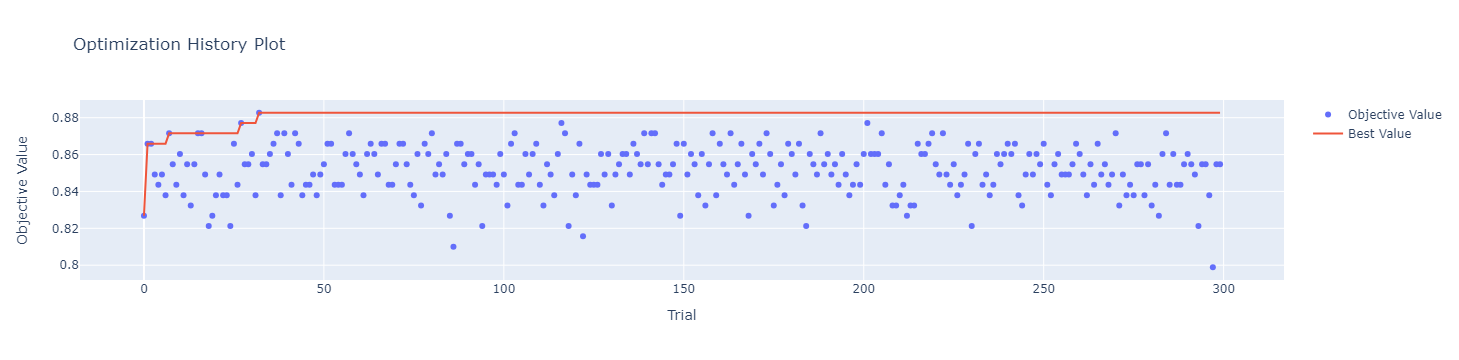

In [16]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

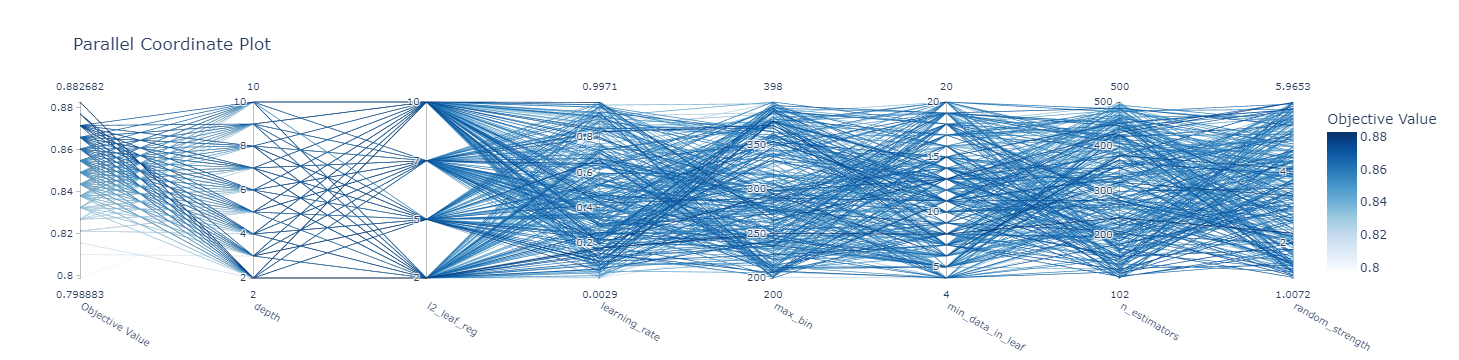

In [17]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

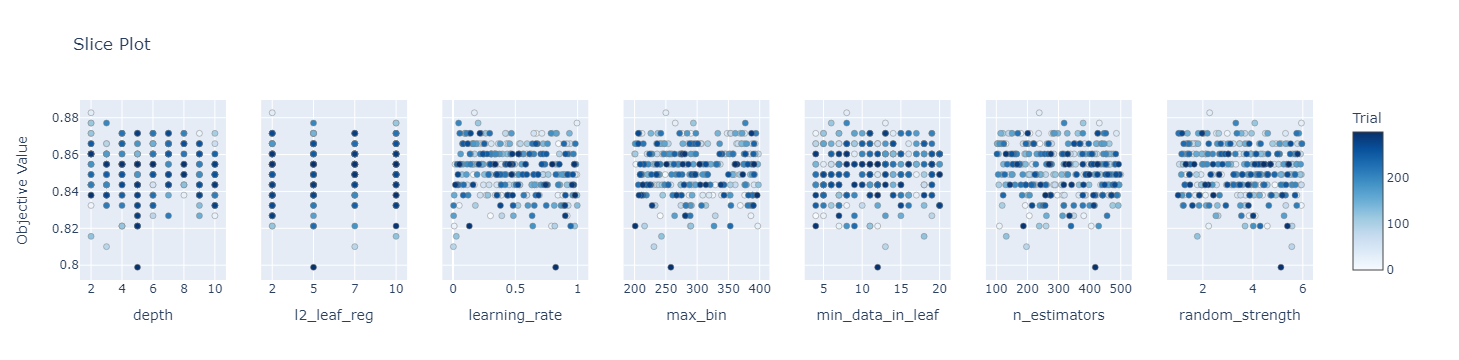

In [18]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

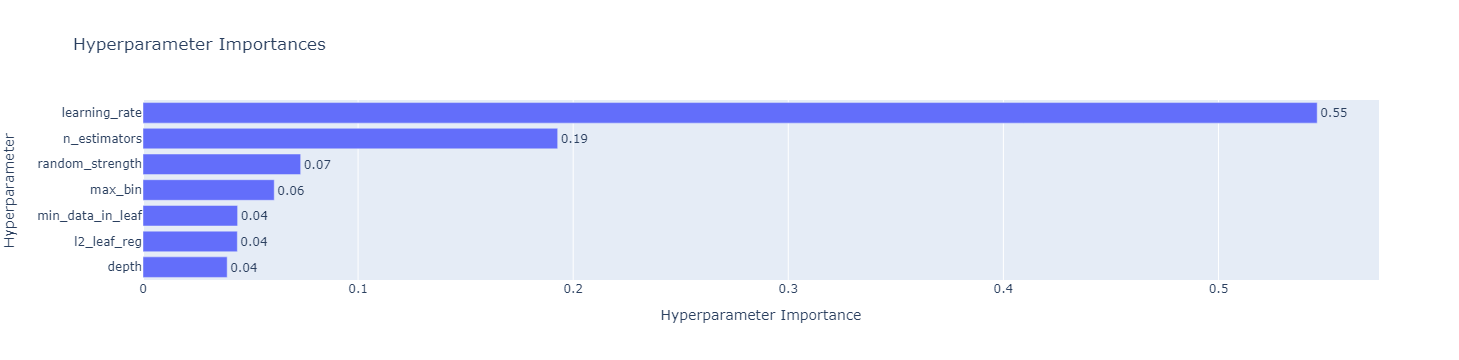

In [19]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

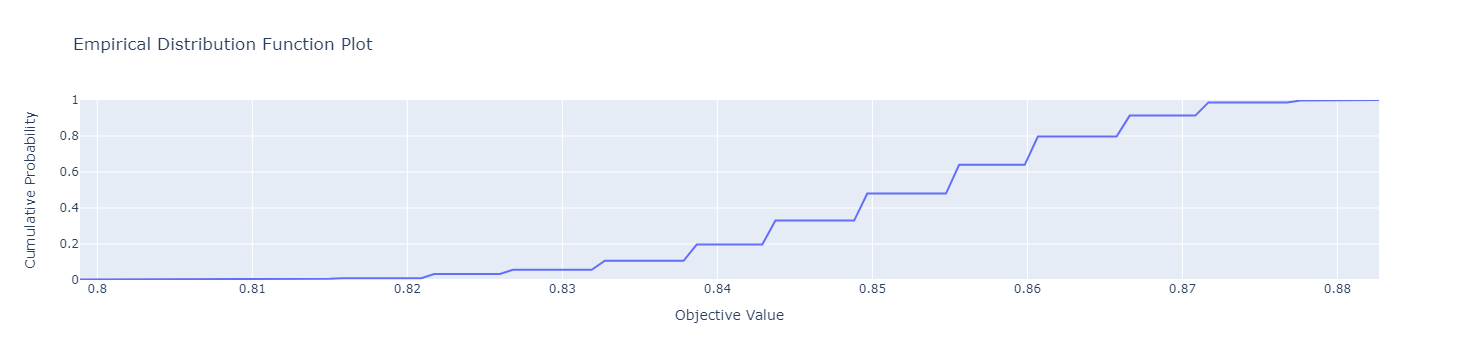

In [20]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [22]:
X_train, X_val, y_train, y_val = preprocessing_data(data_patch + 'train.csv')

def objective(trial):             
                   
    # boundaries for the optimizer's
    max_depth = trial.suggest_int("max_depth", 2, 10)
    criterion = trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"])
    loss = trial.suggest_categorical("loss", ["log_loss", "exponential"])
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    
    # create new model(and all parameters) every iteration
    model = GradientBoostingClassifier(
        max_depth = max_depth,
        criterion = criterion, 
        loss = loss,
        learning_rate = learning_rate,
        n_estimators = n_estimators,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    return acc


# Create "exploration"
study_GBC = optuna.create_study(
    direction="maximize", study_name="Optimizer", sampler=RandomSampler(42)
)

study_GBC.optimize(
    objective, n_trials=2000
)
print('Number of finished trials:', len(study_GBC.trials))
print('Best trial:', study_GBC.best_trial.params)

[I 2024-12-21 17:40:26,947] A new study created in memory with name: Optimizer
[I 2024-12-21 17:40:27,552] Trial 0 finished with value: 0.8547486033519553 and parameters: {'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss', 'learning_rate': 0.016443457513284063, 'n_estimators': 170}. Best is trial 0 with value: 0.8547486033519553.
[I 2024-12-21 17:40:29,796] Trial 1 finished with value: 0.8212290502793296 and parameters: {'max_depth': 9, 'criterion': 'squared_error', 'loss': 'exponential', 'learning_rate': 0.08341182143924175, 'n_estimators': 224}. Best is trial 0 with value: 0.8547486033519553.
[I 2024-12-21 17:40:30,415] Trial 2 finished with value: 0.8491620111731844 and parameters: {'max_depth': 3, 'criterion': 'squared_error', 'loss': 'log_loss', 'learning_rate': 0.029831684879606152, 'n_estimators': 364}. Best is trial 0 with value: 0.8547486033519553.
[I 2024-12-21 17:40:30,982] Trial 3 finished with value: 0.8547486033519553 and parameters: {'max_depth': 3, 'criter

Number of finished trials: 1000
Best trial: {'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'exponential', 'learning_rate': 0.05755478652377264, 'n_estimators': 200}


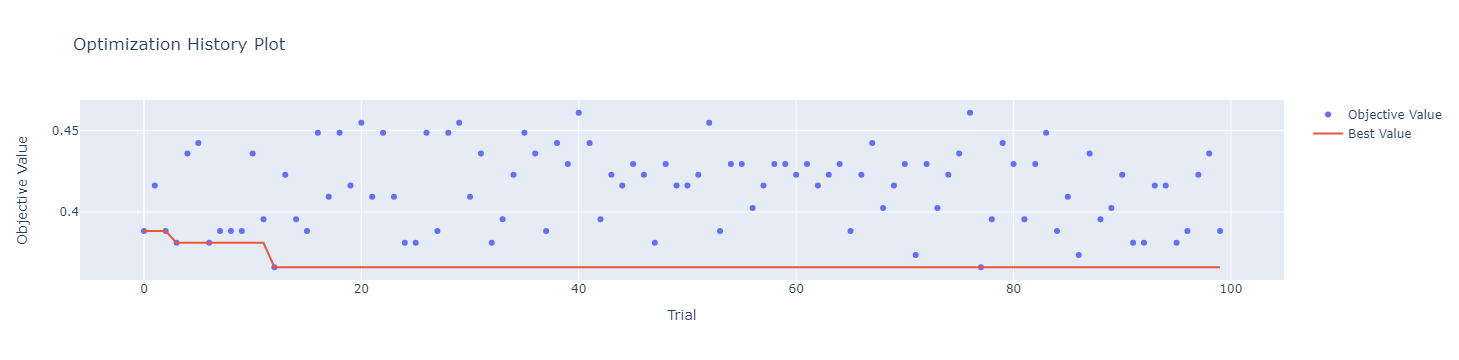

In [53]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study_GBC)

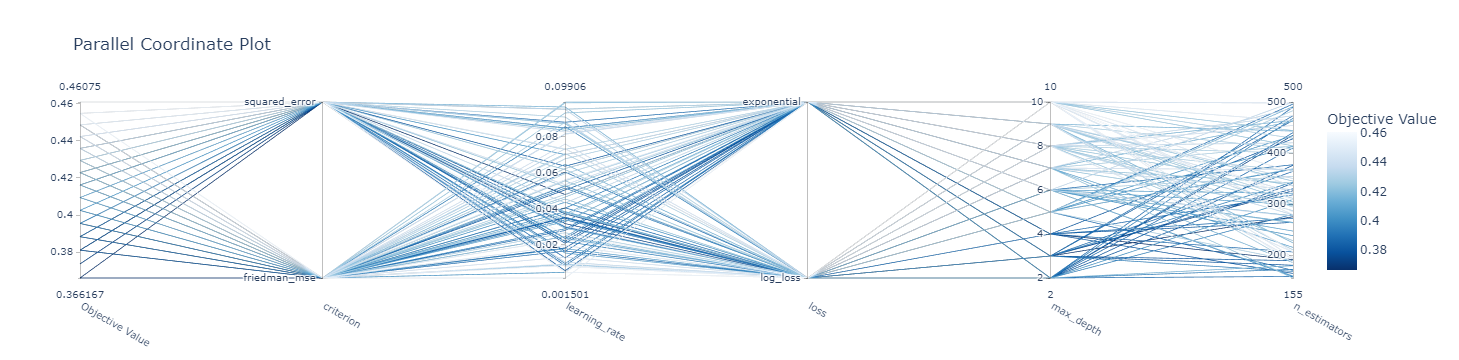

In [54]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_GBC)

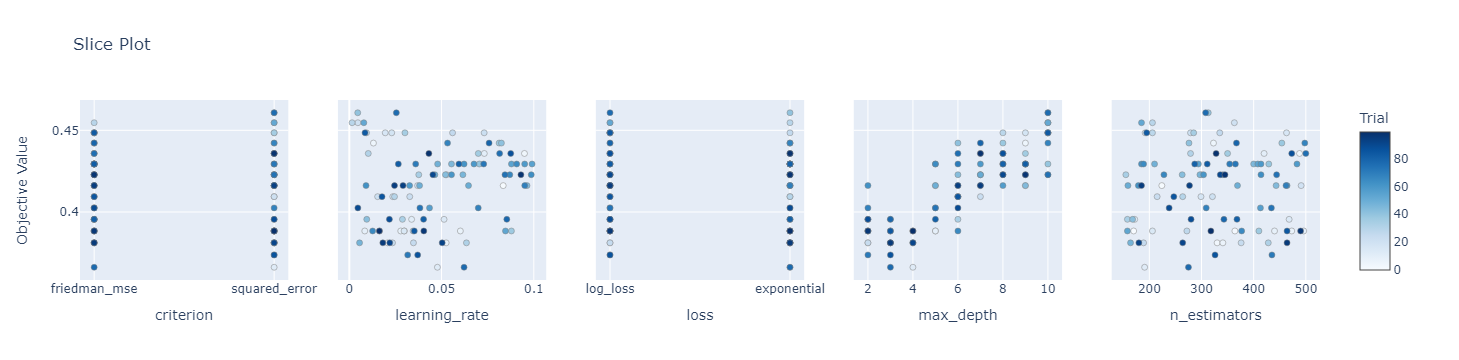

In [55]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study_GBC)

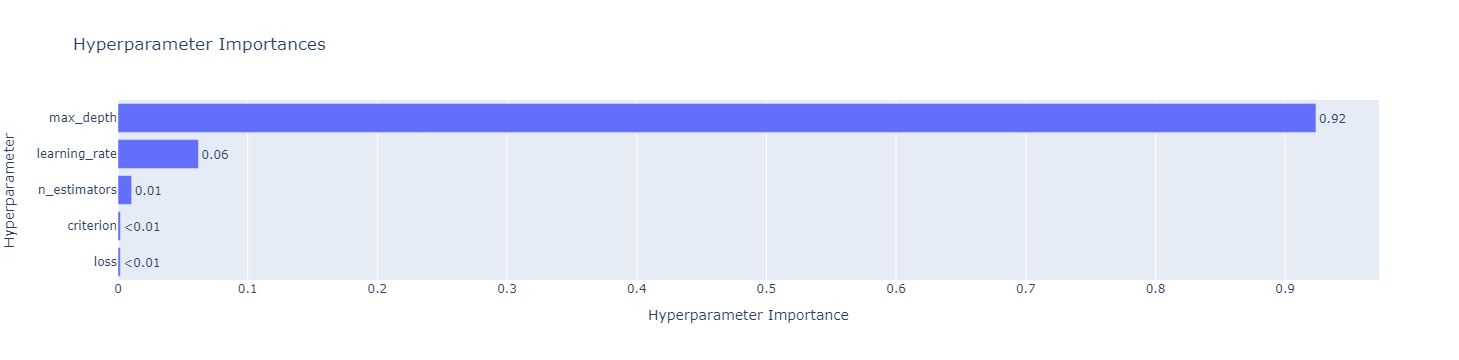

In [56]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study_GBC)

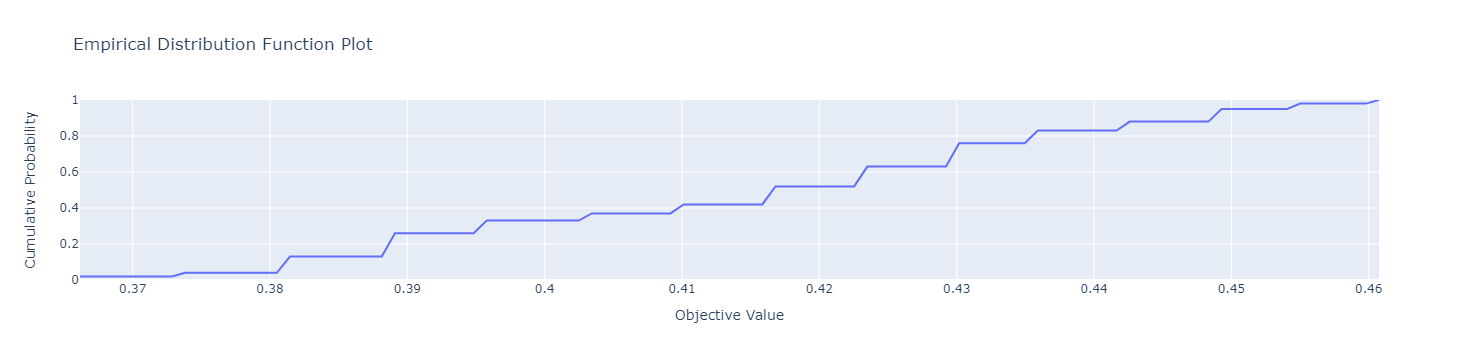

In [57]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study_GBC)

<div style="font-size: 30px">
C get_dummies, PolynomialFeatures, GridSearchCV

In [11]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2)

In [12]:
param_grid = [{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs']},
              {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cholesky']},
              {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['sag']},
              {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0, 0.01, 0.1, 1]}
             ]

gs_lr = GridSearchCV(LogisticRegression(max_iter=50, random_state=2), param_grid, error_score=0.5, cv=skf, n_jobs=3)
tab_models_score('LogisticRegression', gs_lr, plot_score_2, all_data=True)

Наилучшие значения параметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшее значение кросс-валидац. правильности: 0.79


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
param_grid = {'n_neighbors': [3, 5],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 50]}

gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid, error_score=0.5, cv=skf, n_jobs=3)
tab_models_score('KNeighborsClassifier', gs_knn, plot_score_2, all_data=True)

Наилучшие значения параметров: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}
Наилучшее значение кросс-валидац. правильности: 0.70


In [14]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_depth': [3, 5, 7], 
              'max_features': ['sqrt', 'log2']}

gs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('DecisionTreeClassifier', gs_dtc, plot_score_2, all_data=True)

Наилучшие значения параметров: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2'}
Наилучшее значение кросс-валидац. правильности: 0.74


In [15]:
param_grid = {'n_estimators': [10, 20, 50, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_depth': [3, 5, 7, 10], 
              'max_features': [3, 5, 7]}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('RandomForestClassifier', gs_rf, plot_score_2, all_data=True)

Наилучшие значения параметров: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 5, 'n_estimators': 50}
Наилучшее значение кросс-валидац. правильности: 0.80


In [16]:
param_grid = {'learning_rate': [0.001, 0.01],
               'n_estimators': [150, 200],
               'criterion': ['friedman_mse', 'squared_error'],
               'max_depth': [2, 3, 4],
               'loss': ['log_loss', 'exponential']}

gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=2), param_grid, cv=skf, n_jobs=3)
tab_models_score('GradientBoostingClassifier', gs_gb, plot_score_2, all_data=True)

Наилучшие значения параметров: {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 150}
Наилучшее значение кросс-валидац. правильности: 0.81


In [17]:
param_grid = {'gamma': [0.09, 0.099, 0.1, 0.11, 0.12],
               'C': [5, 8, 9, 10, 12]}

gs_svc = GridSearchCV(SVC(random_state=2), param_grid, cv=5, n_jobs=3)
tab_models_score('SVC', gs_svc, plot_score_2, all_data=True)

Наилучшие значения параметров: {'C': 5, 'gamma': 0.1}
Наилучшее значение кросс-валидац. правильности: 0.65


In [18]:
param_grid = {'hidden_layer_sizes': [[20, 50, 10], [30, 60, 15], [10, 20, 5]],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam']}

mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=2), param_grid, cv=5, n_jobs=3)
tab_models_score('MLPClassifier', mlp, plot_score_2, all_data=True)

Наилучшие значения параметров: {'activation': 'identity', 'hidden_layer_sizes': [10, 20, 5], 'solver': 'adam'}
Наилучшее значение кросс-валидац. правильности: 0.81


In [19]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1],
               'n_estimators': [100, 150],
               'max_depth': [2, 3, 4],
               'loss': ['regression', 'cross_entropy']}

gs_lgb = GridSearchCV(LGBMClassifier(random_state=2, verbosity=-1), param_grid, cv=skf, n_jobs=3)
tab_models_score('LGBMClassifier', gs_lgb, plot_score_2, all_data=True)

Наилучшие значения параметров: {'learning_rate': 0.01, 'loss': 'cross_entropy', 'max_depth': 3, 'n_estimators': 150}
Наилучшее значение кросс-валидац. правильности: 0.83


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:737: UserWarning: Found 'loss' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


In [20]:
param_grid = {'learning_rate': [0.01, 0.1, 0.3],
               'max_depth': [2, 3, 4],
               'tree_method': ['auto', 'approx']}

gs_xgb = GridSearchCV(XGBClassifier(random_state=2, objective='binary:logistic'), param_grid, cv=skf, n_jobs=3)
tab_models_score('XGBClassifier', gs_xgb, plot_score_2, all_data=True)

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Наилучшие значения параметров: {'learning_rate': 0.01, 'max_depth': 2, 'tree_method': 'auto'}
Наилучшее значение кросс-валидац. правильности: 0.82


In [21]:
param_grid = {'learning_rate': [0.01, 0.1, 0.3],
               'iterations': [50, 100, 150],
               'max_depth': [3, 4, 6]}

gs_cat = GridSearchCV(CatBoostClassifier(random_state=2, verbose=False), param_grid, cv=skf, n_jobs=3)
tab_models_score('CatBoostClassifier', gs_cat, plot_score_2, all_data=True)

Наилучшие значения параметров: {'iterations': 150, 'learning_rate': 0.01, 'max_depth': 4}
Наилучшее значение кросс-валидац. правильности: 0.82


In [54]:
display(plot_score_2)

,model,train,val
0,LogisticRegression,0.83,0.80
1,KNeighborsClassifier,0.79,0.74
2,DecisionTreeClassifier,0.77,0.70
3,RandomForestClassifier,0.87,0.82
4,GradientBoostingClassifier,0.86,0.83
5,SVC,0.95,0.65
6,MLPClassifier,0.85,0.80
7,LGBMClassifier,0.86,0.82
8,XGBClassifier,0.83,0.80
9,CatBoostClassifier,0.83,0.80


In [24]:
plot_score_1.to_csv('train_val_data_1.csv', sep=',', index=False)
plot_score_2.to_csv('train_val_data_2.csv', sep=',', index=False)

In [2]:
plot_score_1 = pd.read_csv('train_val_data_1.csv', sep=',')
plot_score_2 = pd.read_csv('train_val_data_2.csv', sep=',')

In [3]:
plot_score_1['model'] =plot_score_1['model'].astype(str)
plot_score_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   11 non-null     object 
 1   train   11 non-null     float64
 2   val     11 non-null     float64
dtypes: float64(2), object(1)
memory usage: 396.0+ bytes


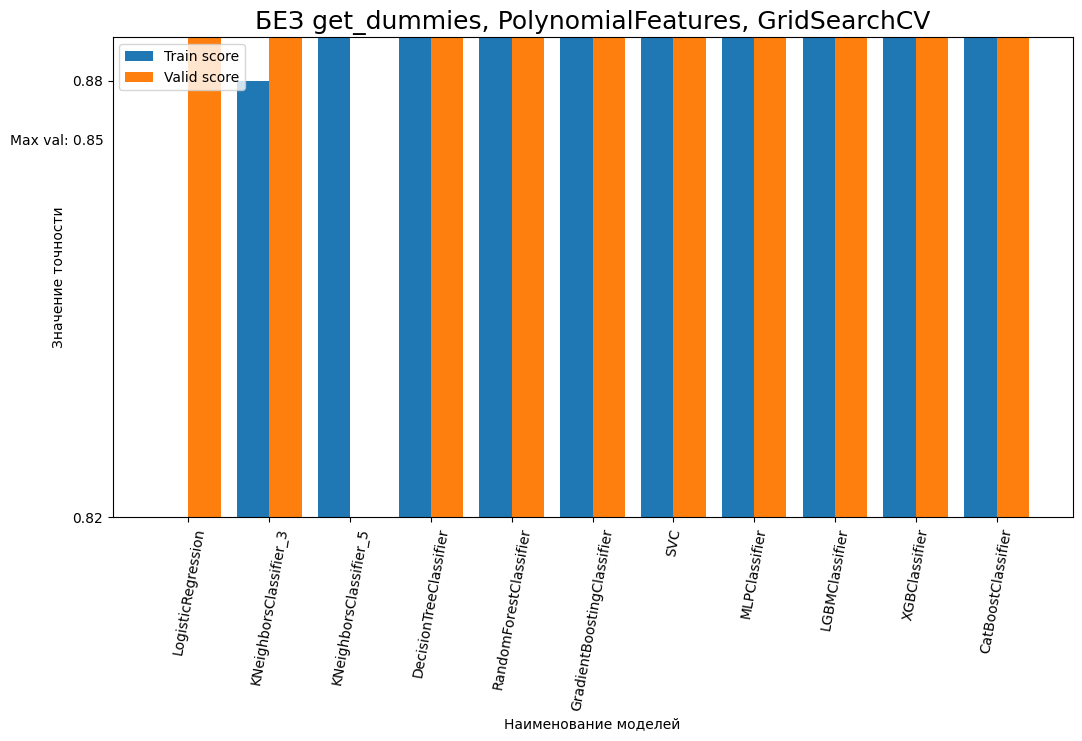

In [25]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 1]) # переменная - график
axes.bar(x = plot_score_1['model'], height = plot_score_1['train'],
        width = -0.4, align = 'edge', label = 'Train score')
axes.bar(x = plot_score_1['model'], height = plot_score_1['val'],
         width = 0.4, align = 'edge', label = 'Valid score')
# Добавляем линию на уровне максимального значения
max_value = np.max(plot_score_1['val'])
plt.axhline(y=max_value, color='r', linestyle='--')
# Добавляем текст с максимальным значением
axes.text(0, float(max_value) - 0.08, f"Max val: {float(max_value):.2f}  ", ha='right', va='bottom', transform=axes.transAxes)
axes.set_ylim(0, 1.1)
axes.legend(loc = 2)
plt.xticks(rotation=80)
plt.title('БЕЗ get_dummies, PolynomialFeatures, GridSearchCV', fontsize=18)
plt.xlabel('Наименование моделей') #Подпись для оси х
plt.ylabel('Значение точности') #Подпись для оси y
plt.legend(loc=2)
plt.show()

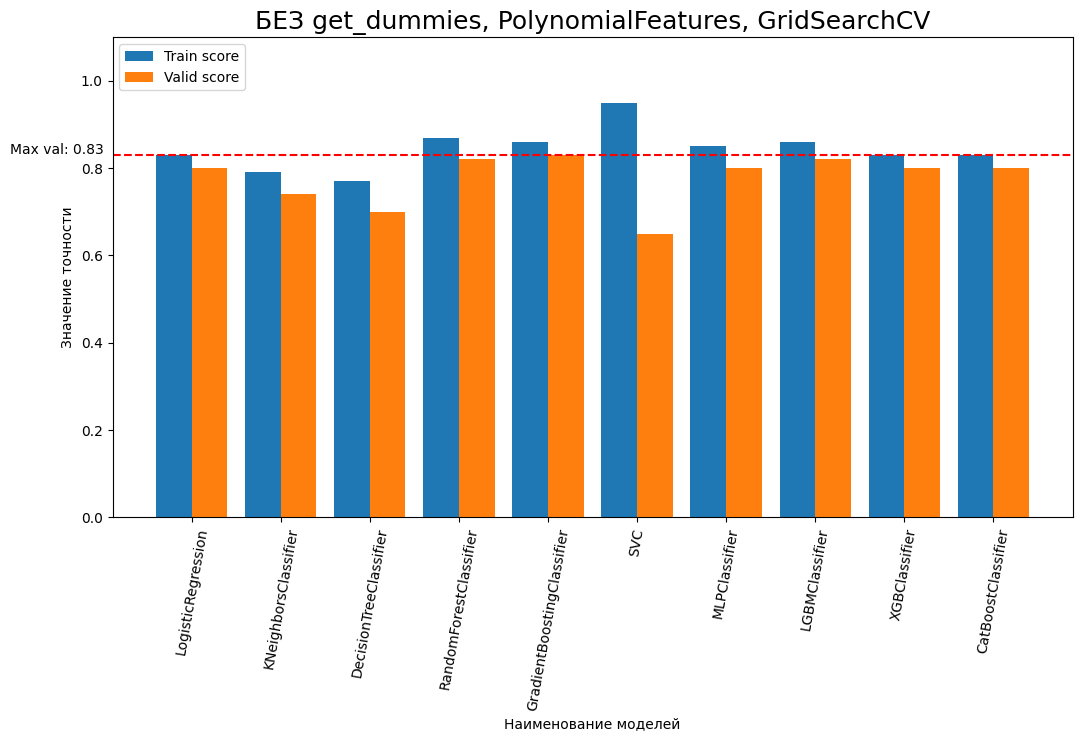

In [59]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 1]) # переменная - график
axes.bar(x = plot_score_2['model'], height = plot_score_2['train'],
        width = -0.4, align = 'edge', label = 'Train score')
axes.bar(x = plot_score_2['model'], height = plot_score_2['val'],
         width = 0.4, align = 'edge', label = 'Valid score')
# Добавляем линию на уровне максимального значения
max_value = np.max(plot_score_2['val'])
plt.axhline(y=max_value, color='r', linestyle='--')
axes.text(0, max_value-0.08, f"Max val: {max_value:.2f}  ", ha='right', va='bottom', transform=axes.transAxes)
axes.set_ylim(0, 1.1)
axes.legend(loc = 2)
plt.xticks(rotation=80)
plt.title('БЕЗ get_dummies, PolynomialFeatures, GridSearchCV', fontsize=18)
plt.xlabel('Наименование моделей') #Подпись для оси х
plt.ylabel('Значение точности') #Подпись для оси y
plt.legend(loc=2)
plt.show()

In [44]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_1)
X_test = preprocessing_data(data_patch + 'test.csv', dummies=False, polynomial=False, test=True)
data = pd.read_csv('gender_submission.csv', sep=',')
data['Survived'] = gbc.predict(X_test)
data.to_csv('gender_submission.csv', sep=',', index=False)

In [45]:
plot_score_1

,model,train,val
0,CatBoostClassifier,0.91,0.87
1,GradientBoostingClassifier,0.91,0.87


In [58]:
gbc = GradientBoostingClassifier(**study_GBC.best_trial.params, random_state=2)
tab_models_score('GradientBoostingClassifier', gbc, plot_score_2)
X_test = preprocessing_data(data_patch + 'test.csv', dummies=False, polynomial=False, test=True)
data = pd.read_csv('gender_submission.csv', sep=',')
data['Survived'] = gbc.predict(X_test)
data.to_csv('gender_submission.csv', sep=',', index=False)

In [59]:
plot_score_2

,model,train,val
0,GradientBoostingClassifier,0.94,0.87


In [21]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
cat = CatBoostClassifier(**study.best_trial.params, random_state=2, verbose=False, cat_features=categorical_features)
tab_models_score('CatBoostClassifier', cat, plot_score_2)
X_test = preprocessing_data(data_patch + 'test.csv', dummies=False, polynomial=False, test=True)
data = pd.read_csv('gender_submission.csv', sep=',')
data['Survived'] = cat.predict(X_test)
data.to_csv('gender_submission.csv', sep=',', index=False)

In [22]:
plot_score_2

,model,train,val
0,CatBoostClassifier,0.91,0.83
1,CatBoostClassifier,0.88,0.85


In [68]:
pd.read_csv('gender_submission.csv', sep=',')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
